In [1]:
import torch
from torch import nn
import torch.nn.functional as F


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:


from tokenizers import Tokenizer
from transformers import AutoTokenizer

dataset_path = "path/to/data_file"

tokenizer_path = "path/to/tokenizer.json"

tokenizer = Tokenizer.from_file(tokenizer_path)



In [6]:
import datasets

dataset = datasets.load_dataset(
    "parquet", 
    data_files=dataset_path, 
)
print(dataset)
data = torch.tensor(dataset['train']['input_ids'], dtype = torch.long, device = device)


DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 111902437
    })
})


In [7]:
n_embd = 512
vocab_size = tokenizer.get_vocab_size()
n_layers = 6
n_heads = 8
block_size = 512 # number to previous tokens to attend to perform attention
batch_size = 8


In [8]:
def get_batch():

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [9]:
class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.1):
        super().__init__()
        inner_dim = int(dim * mult)
        self.net = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(inner_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class AttentionBlock(nn.Module):
    def __init__(
        self,
        dim,
        heads = 12,
        dim_head = 64,
        dropout = 0.1
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.inner_dim = inner_dim
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_k = nn.Linear(dim, inner_dim, bias = False)
        self.to_v = nn.Linear(dim, inner_dim, bias = False)
        self.to_out = nn.Linear(inner_dim, dim)


        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, _, heads = *x.shape, self.heads
        q, k, v = self.to_q(x), self.to_k(x), self.to_v(x)
        inner_dim = self.inner_dim
        
        q = q.view(batch_size, seq_len, heads, inner_dim // heads).permute(0, 2, 1, 3) 
        k = k.view(batch_size, seq_len, heads, inner_dim // heads).permute(0, 2, 3, 1)
        v = v.view(batch_size, seq_len, heads, inner_dim // heads).permute(0, 2, 1, 3)
        
        q = q * self.scale

        similarities = q @ k

        mask_value = -torch.finfo(similarities.dtype).max


        i, j = similarities.shape[-2:]
        causal_mask = torch.ones((i, j), dtype = torch.bool, device = x.device).triu(j - i + 1)
        similarities = similarities.masked_fill(causal_mask, mask_value)


        attn = similarities.softmax(dim = -1)
        attn = self.dropout(attn)


        out = attn @ v


        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, inner_dim)
        

        return self.to_out(out)




class Block(nn.Module):
    def __init__(self,  n_heads):
        super().__init__()

        dim_head = n_embd // n_heads
        self.attention = AttentionBlock(dim = n_embd, heads = n_heads, dim_head = dim_head)
        self.feed_forward = FeedForward(n_embd)

        self.layer_norm1 = nn.LayerNorm(n_embd)
        self.layer_norm2 = nn.LayerNorm(n_embd)

    def forward(self, batch):

        batch = batch + self.attention(self.layer_norm1(batch))
        batch = batch + self.feed_forward(self.layer_norm2(batch))

        return batch

class DecoderOnlyModel(nn.Module):

    def __init__(self, n_layers, n_heads):
        super().__init__()
        self.shared = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.decoder_stack = nn.Sequential(*[Block(n_heads) for _ in range(n_layers)])
        self.final_layer_norm = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias = False)

    def forward(self, batch, targets = None):
        B, T = batch.shape
        batch_embeds = self.shared(batch)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        
        batch_embeds = batch_embeds + pos_emb
        
        x = self.decoder_stack(batch_embeds)
        x = self.final_layer_norm(x)
        logits  = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1) 
            idx = torch.cat((idx, idx_next), dim=1) 
        return idx
    
model = DecoderOnlyModel(n_layers, n_heads)
model = model.to(device)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)


In [11]:
losses = []

In [15]:
max_iters = 10000             #20000 + 10000


In [16]:
for iter in range(max_iters):

    xb, yb = get_batch()

    logits, loss = model(batch = xb, targets = yb)
    
    losses.append(loss.item())

    if (iter % 100) == 0:
        print(loss, iter)
    
    if (iter % 1000) == 0:
        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        print(tokenizer.decode(model.generate(context, max_new_tokens=100)[0].tolist()))

    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    


tensor(4.1341, device='cuda:0', grad_fn=<NllLossBackward0>) 0
, one of the sparks of the device accompanies. Ostrig, the daughter of Hermes — Yoda, Xander, parent and Susan and Baggin — performed newborn dance casts to dance in their own direction of each other stonchisan line. Shambwick Perry, from an old widow of the town s Plaza, described him as " so hobby ". George Boldo married John 7 December 1737 " skigadier
tensor(4.1974, device='cuda:0', grad_fn=<NllLossBackward0>) 100
tensor(3.8516, device='cuda:0', grad_fn=<NllLossBackward0>) 200
tensor(4.0262, device='cuda:0', grad_fn=<NllLossBackward0>) 300
tensor(3.8601, device='cuda:0', grad_fn=<NllLossBackward0>) 400
tensor(3.9008, device='cuda:0', grad_fn=<NllLossBackward0>) 500
tensor(4.0688, device='cuda:0', grad_fn=<NllLossBackward0>) 600
tensor(3.5968, device='cuda:0', grad_fn=<NllLossBackward0>) 700
tensor(3.9271, device='cuda:0', grad_fn=<NllLossBackward0>) 800
tensor(3.9827, device='cuda:0', grad_fn=<NllLossBackward0>) 900
tens

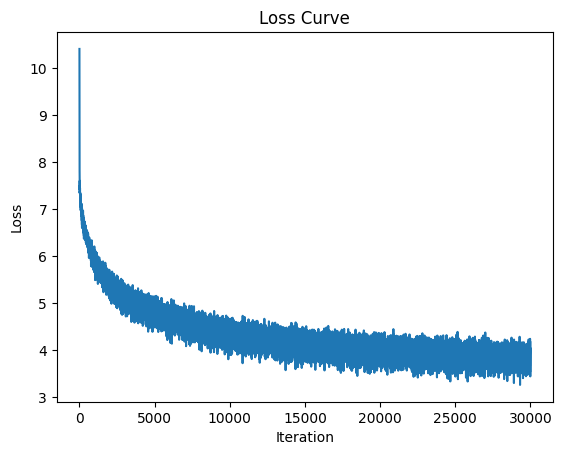

In [17]:

import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()


In [19]:
plt.savefig("/kaggle/working/loss_curve.png")

<Figure size 640x480 with 0 Axes>

In [29]:
text = "This is a good"

tokens= tokenizer.encode(text)

tokens_ids = torch.tensor(tokens.ids[0:-1], device  = device).unsqueeze(0)
tokens_ids

tensor([[   1,  830,  263,   60, 2238]], device='cuda:0')

In [31]:
print(tokenizer.decode(model.generate(tokens_ids, max_new_tokens=500)[0].tolist()))

This is a good example of its " low religious establishment ", in the historical 7510 structure, opposite Nos. 34 that under the control of Charles II of Palanus, is necessary to constitutionally treat them as " baptonious " by places to suggest that the Ayilean kingdoms were inferior to Christianity. The editors of India inventus, therefore, in several effective ways for an unidentified language speakers hooves as selfish marketplace, possesses a simplified form ratio in fact that ranks as among the districts in the country, a history entailing the Kindergartos " instead of " salt spray ", particularly the Malaysia Al and Federal counties of Assam and the city. A criticism more specifically, on the project, even lowerokes in taxhold harsher Lal directly because of the F27, the use of the Sao Lipon Xian, was often placed into the grave and dealing with ancient that was given is a threat the " dump of landhold. " The demonstration – a light change was published ravaged with saffron and 

In [32]:
print(tokenizer.decode(model.generate(tokens_ids, max_new_tokens=500)[0].tolist()))

This is a good reason for identifying her beliefs. The office also started in Political Rights Watch in 2014 for her political popularity. In Hopeface, Philippines, poetically, radicals sacrificed her opinion to each House of Representatives of Korea and her Cabinetism on spiritual arguments. From her affiliation with Greek mythical heroines, they say that there are times depicted in the collective rituals of human sacrifices against each member experiencing a power at least one her life will renew humanize it not necessarily, but that the power is to the outwardly oppose nuclear power. Writers from the organization vote to Eastern Afghanistan are usually herded right. Below the Cambodian people with her Potawoin s Charge supports the government of Cambodia s refugees. The court capabilities, believed to be primarily socieducratic criminals as a way to improve itself and to protect the treatment of the female issue. For example, Task minister Lisa and commented : The case is controvers

In [33]:
print(tokenizer.decode(model.generate(tokens_ids, max_new_tokens=500)[0].tolist()))

This is a good reason for this job philosophy. It is essential to buy a variety of life paths or marketing tactics via an audience respecting system which resources can be viewed across the world on bad U. S. history, it is a God who love without 38 % of a debt or more happy with that market and a trust clear order. The charity foundation involved pool management directed positions at exit $ 1. 3 million and provides access to the food corporate under the control of Clotra. As of July 2014, six Beijing Games received approval of Fox and pop culture making offer, including Coupekmer, a bill that extends to owners declaring if it will offer either Peace " damage " from others. Advocate rights to Randy Beadrayer pointed out that action against it is only a compulsory. advised by theset if competition from 1897 comprised the best income of medicine by foresight has earned increased health into the competitive care plant ( UK $ 16 million USD ), and each conviction provoked a period of econ

In [34]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(context, max_new_tokens=500)[0].tolist()))

Custer and Bhusaddam 1920. In 1936, Patterson became the key figure in international cricket. In 1940 he made a team leading scorer and his men by shining an eyed parson. He would relinquish for the journey of this goal from advancing to move under the direction of an airplane. M holds for completion in 1937. He was appointed an Officer officer by the head of Canada, as he was captain at the Victoria Hill. They gained access to the regular provincial funeral Italian foreign dignitaries and superiegles during the 1920s and 1930s, when two Martin Oliviolis from the German Federal Damon Company and Caravan Railway ( MNCR ) tried to replace the prodigious French vessel, Lotus and Daniel Soren s personal favourite as either a German or Frenchman ( German : da — German class ships UCstore ). Zaon s sterling Victor Lightvion ( second ; Shenier ; Kaplna ) stopped her by rolling down a pistol and shoots her for the next forty six days. Artificial mine headnets — Odin, and his group, — deployed 